In [1]:
!pip install stable-baselines3

In [2]:
!pip install pettingzoo

  Using cached pettingzoo-1.25.0-py3-none-any.whl.metadata (8.9 kB)
Using cached pettingzoo-1.25.0-py3-none-any.whl (852 kB)


In [3]:
!pip install 'shimmy>=2.0'

In [4]:
!pip install modin[ray]

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

In [6]:
import math
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from typing import Dict
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C, SAC
from gym.wrappers import FlattenObservation
from typing import Tuple, Dict, Optional, Any
import matplotlib.pyplot as plt
import math
from stable_baselines3.common.utils import get_linear_fn
import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [ ]:
def optimal_linear_kyle(sigma_u, mean_v, sigma_v):
    beta = math.sqrt(sigma_u ** 2 / sigma_v)  # Insider's coefficient
    lambda_ = 0.5 * math.sqrt(sigma_v / (sigma_u ** 2))  # MM's coefficient
    return beta, lambda_

def set_linear_price(y, sigma_v, sigma_u, mean_v):
    beta, lambda_ = optimal_linear_kyle(sigma_u, mean_v, sigma_v)
    return mean_v + lambda_ * y

In [ ]:
class KyleModelEnv(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, sigma_v=1.0, sigma_u=1.0, p0=0.5, T=1, gamma=0.9):
        super(KyleModelEnv, self).__init__()

        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.T = T
        self.gamma = gamma
        self.actual_actions = []

        # Define action and observation spaces
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        self.observation_space = spaces.Dict({
            'v': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        })

        self.reset()

    def reset(self, seed=None, options=None):
        """Reset environment to initial state"""
        super().reset(seed=seed)

        self.v = np.random.normal(self.p0, self.sigma_v)  # True asset value
        self.p = self.p0
        self.t = 0

        obs = self._get_insider_obs()
        info = {}
        return obs, info  # Gymnasium requires (obs, info)

    def _get_insider_obs(self):
        return {
            'v': np.array([self.v], dtype=np.float32)
        }

    def step(self, action):
        """Execute one step"""
        if self.t >= self.T:
            raise ValueError("Episode has already ended")

        scaled_action = action * 10
        self.actual_actions.append(scaled_action[0])

        x = scaled_action[0]
        u = np.random.normal(0, self.sigma_u)
        y = x + u
        lambda_kyle = 0.5 * math.sqrt(self.sigma_v / (self.sigma_u ** 2))
        p_new = self.p + lambda_kyle * y

        insider_profit = (self.v - p_new) * x

        # Update state
        self.p = p_new
        self.t += 1

        terminated = (self.t >= self.T)  # natural end
        truncated = False  # No time/truncation logic here

        obs = self._get_insider_obs()
        info = {}

        return obs, insider_profit, terminated, truncated, info



# Example usage with Gym interface
print("Testing Kyle model with Gym interface")

env_insider = KyleModelEnv()

# Initialize the model

clip_range_schedule = get_linear_fn(start=0.3, end=0.2, end_fraction=0.9)




policy_kwargs = dict(
    net_arch=[64]
)

model_insider = PPO(
    "MultiInputPolicy",
    env_insider,
    verbose = 1,
    learning_rate = 0.001,
    clip_range = clip_range_schedule,
    policy_kwargs=policy_kwargs,
    ent_coef = 0.03

)

model_insider.learn(total_timesteps=55_000)
model_insider.save("ppo_mm")

# Test trained agent
obs = env_insider.reset()
obs = env_insider.reset()

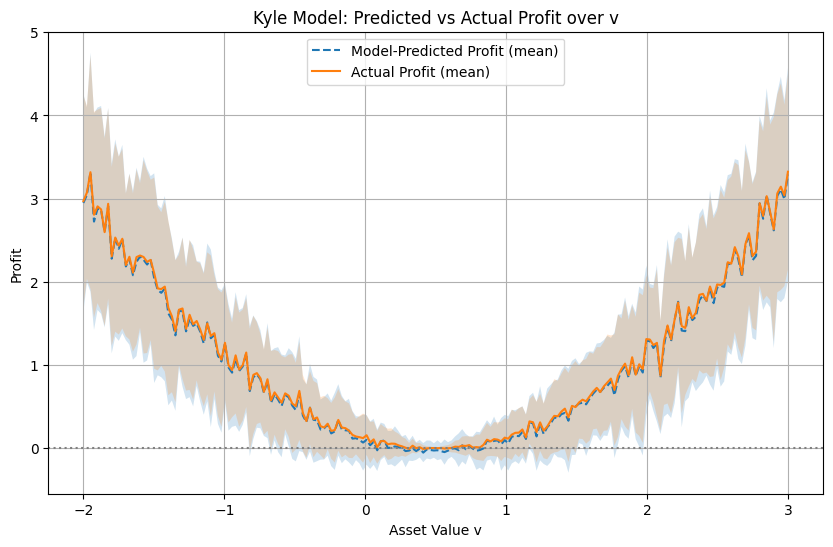

In [71]:
def evaluate_profits(env, start_point, end_point, model, num_points = 100, num_trials = 50):
    values = np.linspace(start_point, end_point, num_points)
    predicted_profits = np.zeros((num_trials, num_points))
    actual_profits = np.zeros((num_trials, num_points))


    for i in range(num_points):

        # Fix environment
        v = values[i]
        obs, dict_ = env.reset()
        obs['v'][0] = v
        env.v = v

        for j in range(num_trials):

            #  and draw fixed v and u


            u = np.random.normal(0, env.sigma_u)

            beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)


            action, _ = model.predict(obs)
            # 1. Scale PPO's normalized action to market order size

            x = action[0] * 10  # scale to actual action

            y = x + u
            p_new = env.p0 + lambda_kyle * y

            # Predicted profit using known v and expected price impact
            predicted_profit = (v - p_new) * x

            # Actual profit using random u

            actual_x = beta_kyle * (v - env.p0)
            y = actual_x + u
            p_new = env.p0 + lambda_kyle * y
            actual_profit = (v - p_new) * actual_x

            predicted_profits[j][i] = predicted_profit
            actual_profits[j][i] = actual_profit


    return predicted_profits, actual_profits


def plot_profits(predicted_profits, actual_profits, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Profit (mean)", linestyle='--')
    plt.fill_between(values, predicted_mean - predicted_std, predicted_mean + predicted_std, alpha=0.2)

    plt.plot(values, actual_mean, label="Actual Profit (mean)", linestyle='-')
    plt.fill_between(values, actual_mean - actual_std, actual_mean + actual_std, alpha=0.2)

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Profit")
    plt.title("Kyle Model: Predicted vs Actual Profit over v")
    plt.legend()
    plt.grid(True)
    plt.show()





start_point = -2
end_point = 3
num_points = 200
num_trials = 100
predicted, actual = evaluate_profits(env_insider, start_point, end_point, model_insider, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)




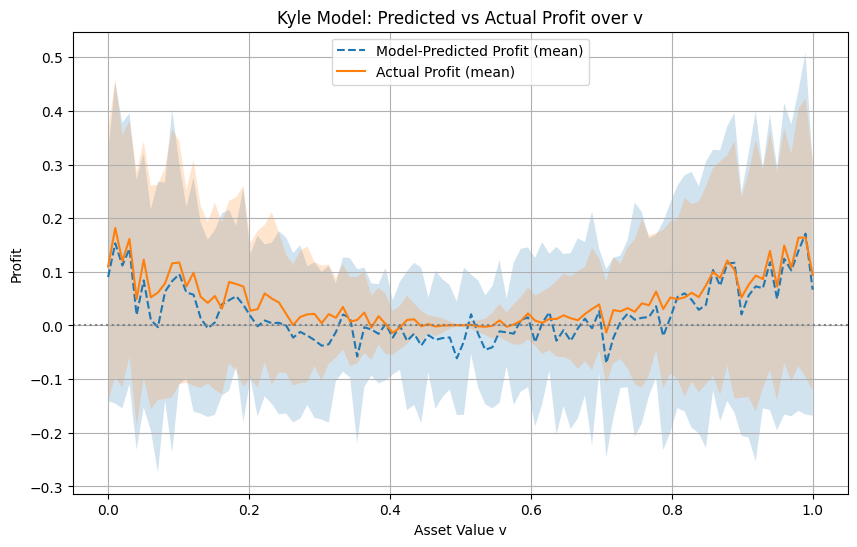

In [56]:
start_point = 0
end_point = 1
num_points = 100
num_trials = 50
predicted, actual = evaluate_profits(env_insider, start_point, end_point, model_insider, num_points = 100)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)  # shape (100,)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_profits(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)


In [57]:

class KyleModelEnvMM(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, sigma_v=1.0, sigma_u=1.0, p0=0.5, T=1, gamma=0.9):
        super(KyleModelEnvMM, self).__init__()

        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.T = T
        self.gamma = gamma
        self.actual_actions = []

        self.beta_kyle, _ = optimal_linear_kyle(self.sigma_u, self.p0, self.sigma_v)

        # Define action space (Market Maker's price guess)
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        # Observation space for the market maker
        self.observation_space = spaces.Dict({
            'y': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'p0': spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'sigma_v': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'sigma_u': spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
        })

    def reset(self, *, seed=None, options=None):
        """Reset the environment to initial state"""
        super().reset(seed=seed)

        # True asset value is drawn from N(p0, sigma_v^2)
        self.v = np.random.normal(self.p0, self.sigma_v)

        # Initialize state variables
        self.p = self.p0
        self.t = 0

        # Generate initial observation
        self.x = self.beta_kyle * (self.v - self.p0)
        u = np.random.normal(0, self.sigma_u)
        self.y = self.x + u

        obs = self._get_mm_obs()
        info = {}
        return obs, info  # Gymnasium requires (obs, info)

    def _get_mm_obs(self) -> Dict[str, np.ndarray]:
        return {
            'y': np.array([self.y], dtype=np.float32),
            'p0': np.array([self.p], dtype=np.float32),
            'sigma_v': np.array([self.sigma_v], dtype=np.float32),
            'sigma_u': np.array([self.sigma_u], dtype=np.float32)
        }

    def step(self, action):
        """Execute one step of the environment"""
        if self.t >= self.T:
            raise ValueError("Episode has already ended")

        # Scale PPO's normalized action to market price guess
        scaled_action = action[0] * 10
        self.actual_actions.append(scaled_action)

        # Market maker's loss function (negative MSE against true value)
        mm_loss = -((scaled_action - self.v) ** 2)

        # Update timestep
        self.t += 1

        terminated = (self.t >= self.T)  # natural termination
        truncated = False  # no time truncation here

        obs = self._get_mm_obs()
        info = {}

        return obs, mm_loss, terminated, truncated, info







# Example usage with Gym interface
print("Testing Kyle model with Gym interface")

env_mm = KyleModelEnvMM()

# Initialize the model

clip_range_schedule = get_linear_fn(start=0.3, end=0.2, end_fraction=0.9)




policy_kwargs = dict(
    net_arch=[64,64]
)

model_mm = PPO(
    "MultiInputPolicy",
    env_mm,
    verbose = 1,
    learning_rate = 0.001,
    clip_range = clip_range_schedule,
    policy_kwargs=policy_kwargs,
    ent_coef = 0.03

)

model_mm.learn(total_timesteps=75_000)
model_mm.save("ppo_mm")

# Test trained agent
obs = env_mm.reset()

Testing Kyle model with Gym interface
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/utils.py:195: UserWarning: get_linear_fn() is deprecated, please use LinearSchedule() instead
  warnings.warn("get_linear_fn() is deprecated, please use LinearSchedule() instead")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -55.5    |
| time/              |          |
|    fps             | 1116     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | -47         |
| time/                   |             |
|    fps                  | 800         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.086519174 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.297       |
|    entropy_loss         | -1.29       |
|    explained_variance   | -0.000592   |
|    learning_rate        | 0.

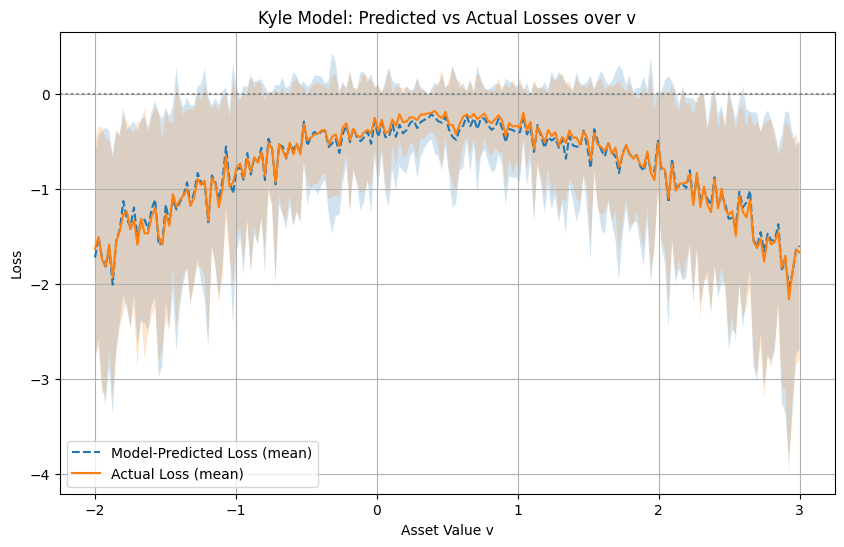

In [59]:
def evaluate_losses(env, start_point, end_point, model, num_points = 100, num_trials = 50):
    values = np.linspace(start_point, end_point, num_points)
    predicted_losses = np.zeros((num_trials, num_points))
    actual_losses = np.zeros((num_trials, num_points))


    for i in range(num_points):

        # Fix environment
        v = values[i]
        obs, dict_ = env.reset()
        env.v = v

        for j in range(num_trials):

            #  and sample u


            u = np.random.normal(0, env.sigma_u)

            beta_kyle, lambda_kyle = optimal_linear_kyle(env.sigma_u, env.p0, env.sigma_v)
            x = beta_kyle * (v - env.p0)


            y = x + u
            obs['y'] = np.array([y], dtype=np.float32)

            # Scale PPO's normalized action to market order size
            action, _ = model.predict(obs)
            scaled_action = action[0] * 10  # scale to actual action




            kyle_price = env.p0 + lambda_kyle * y

            predicted_loss = - ((scaled_action - v) ** 2)
            actual_loss = - ((v - kyle_price) ** 2)

            predicted_losses[j][i] = predicted_loss
            actual_losses[j][i] = actual_loss
            if actual_loss > 20:
                print(f"beta kyle : {beta_kyle}")
                print(f"lambda kyle : {lambda_kyle}")
                print(f"predicted loss : {predicted_loss}")
                print(f"actual loss : {actual_loss}")
                print(f"scaled action : {scaled_action}")
                print(f"kyle price : {kyle_price}")
                print(f"x : {x}")
                print(f"y : {y}")
                print(f"u : {u}")
                print(f"v : {v}")


    return predicted_losses, actual_losses


def plot_losses(predicted_losses, actual_losses, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std):
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(values, predicted_mean, label="Model-Predicted Loss (mean)", linestyle='--')
    plt.fill_between(values, predicted_mean - predicted_std, predicted_mean + predicted_std, alpha=0.2)

    plt.plot(values, actual_mean, label="Actual Loss (mean)", linestyle='-')
    plt.fill_between(values, actual_mean - actual_std, actual_mean + actual_std, alpha=0.2)

    plt.axhline(0, color='gray', linestyle=':')
    plt.xlabel("Asset Value v")
    plt.ylabel("Loss")
    plt.title("Kyle Model: Predicted vs Actual Losses over v")
    plt.legend()
    plt.grid(True)
    plt.show()





start_point = -2
end_point = 3
num_points = 200
num_trials = 100
predicted, actual = evaluate_losses(env_mm, start_point, end_point, model_mm, num_points)
values = np.linspace(start_point, end_point, num_points)

# Compute mean and std for each point in linspace
predicted_mean = predicted.mean(axis=0)
predicted_std = predicted.std(axis=0)

actual_mean = actual.mean(axis=0)
actual_std = actual.std(axis=0)

plot_losses(predicted, actual, values, predicted_mean, predicted_std,
                                                                 actual_mean, actual_std)




In [9]:
from pettingzoo.utils import AECEnv, agent_selector, aec_to_parallel
from ray.rllib.env import PettingZooEnv
from ray import tune
import ray
import numpy as np
from gymnasium import spaces
from pettingzoo.utils import ParallelEnv
from ray.rllib.env import PettingZooEnv
from ray import tune
import ray

2025-08-11 20:01:15,005	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
/usr/local/lib/python3.11/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [10]:
import functools

In [11]:
class KyleOnePeriodAEC(ParallelEnv):
    metadata = {
        "render_modes": ["human"],
        "name": "KyleOnePeriodParallel",
    }

    def __init__(self, sigma_v=1.0, sigma_u=1.0, p0=0.5, gamma = 0.9, T = 1):
        super().__init__()
        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.timestep = 0
        self.gamma = gamma
        self.T = T

        self.possible_agents = ["insider", "market_maker"]
        self.render_mode = None  # add this line

        self.action_spaces = {
            "insider": spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32),
            "market_maker": spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        }

        self.observation_spaces = {
            "insider": spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
            "market_maker": spaces.Box(low=-10, high=10, shape=(4,), dtype=np.float32),
        }




    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self.rewards = {a: 0 for a in self.agents}

        self.terminations = {a: False for a in self.agents}
        self.truncations = {a: False for a in self.agents}

        self.infos = {a: {} for a in self.agents}
        self.timestep = 0

        # Sample true value
        self.v = np.random.normal(self.p0, self.sigma_v)
        self.u = np.random.normal(0, self.sigma_u)
        self.p = 0
        self.y = 0

        observations = {}
        observations["insider"] = self.observe_insider()
        observations["market_maker"] = self.observe_market_maker()

        # Get dummy infos. Necessary for proper parallel_to_aec conversion
        infos = {a: {} for a in self.agents}


        return observations, infos

    def observe_insider(self):
        return np.array([self.v, self.p0, self.sigma_v**2, self.sigma_u**2], dtype=np.float32)

    def observe_market_maker(self):
        return np.array([self.p0, self.sigma_v**2, self.sigma_u**2, self.y], dtype=np.float32)

    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return self.action_spaces[agent]


    def step(self, actions):
        # Execute actions
        insider = actions["insider"]
        market_maker = actions["market_maker"]

        # Check termination conditions
        terminations = {a: False for a in self.agents}
        truncations = {a: False for a in self.agents}
        rewards = {a: 0 for a in self.agents}




        self.timestep += 1
        if self.timestep >= self.T:
            terminations["insider"] = True
            terminations["market_maker"] = True
            self.agents = []



        insider_action = insider[0] * 10
        market_maker_action = market_maker[0] * 10


        self.y = insider_action + self.u
        insider_profit = (self.v - market_maker_action) * insider_action
        market_maker_loss = -((market_maker_action - self.v) ** 2)

        rewards = {}
        rewards["insider"] = insider_profit
        rewards["market_maker"] = market_maker_loss

        self.rewards = rewards





        # Get observations
        observations = {}
        observations["insider"] = self.observe_insider()
        observations["market_maker"] = self.observe_market_maker()

        # Get dummy infos (not used in this example)
        infos = {a: {} for a in self.agents}


        return observations, rewards, terminations, truncations, infos

    def render(self):
        print(f"Step: {self.timestep}")
        print(f"True value v: {self.v:.2f}")
        print(f"Order flow y: {self.y:.2f}")
        insider_reward = self.rewards["insider"]
        print(f"Agents' rewards: {insider_reward}")




In [12]:
from pettingzoo.test import parallel_api_test

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [19]:
env = KyleOnePeriodAEC()
parallel_api_test(env, num_cycles=1_000_000)

env = KyleOnePeriodAEC()
parallel_api_test(env, num_cycles=1_000_000)

Passed Parallel API test
Passed Parallel API test


In [20]:
from ray.rllib.algorithms.ppo import PPOConfig

config = PPOConfig()
print(config.rollouts)          # should print <bound method ...>
print(type(config.rollouts))    # should print <class 'method'>


<bound method Deprecated.<locals>._inner.<locals>._ctor of <ray.rllib.algorithms.ppo.ppo.PPOConfig object at 0x7a5baa7cf290>>
<class 'method'>


In [41]:
import os

import ray
import supersuit as ss
from ray import tune
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.env.wrappers.pettingzoo_env import ParallelPettingZooEnv
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.tune.registry import register_env
from torch import nn

from pettingzoo.butterfly import pistonball_v6

import os
import ray
from ray import tune
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.env.wrappers.pettingzoo_env import ParallelPettingZooEnv
from ray.tune.registry import register_env

def env_creator(config):
    # Create your custom environment
    env = KyleOnePeriodAEC(
        sigma_v=config.get("sigma_v", 1.0),
        sigma_u=config.get("sigma_u", 1.0),
        p0=config.get("p0", 0.5),
        gamma=config.get("gamma", 0.9),
        T=config.get("T", 1)
    )
    return env

if __name__ == "__main__":
    ray.init()

    env_name = "KyleOnePeriodParallel"

    # Register the environment
    register_env(
        env_name,
        lambda config: ParallelPettingZooEnv(env_creator(config))
    )

    # Configuration
    config = (
        PPOConfig()
        .environment(
            env=env_name,
            clip_actions=True,
            env_config={
                "sigma_v": 1.0,
                "sigma_u": 1.0,
                "p0": 0.5,
                "gamma": 0.9,
                "T": 1
            }
        )
        .env_runners(
            num_env_runners=4,
            rollout_fragment_length=128,
            num_envs_per_env_runner=1
        )
        .training(
            train_batch_size=512,
            lr=2e-5,
            gamma=0.99,
            lambda_=0.9,
            use_gae=True,
            clip_param=0.4,
            grad_clip=None,
            entropy_coeff=0.1,
            vf_loss_coeff=0.25,
            num_epochs=10,
            model={
                "fcnet_hiddens": [64, 64],  # Simple MLP for your low-dim observations
                "fcnet_activation": "tanh",
            }
        )
        .multi_agent(
            policies=["insider_policy", "market_maker_policy"],
            policy_mapping_fn=lambda agent_id, *args, **kwargs: {
                "insider": "insider_policy",
                "market_maker": "market_maker_policy"
            }[agent_id],
            policies_to_train=["insider_policy", "market_maker_policy"]
        )
        .debugging(log_level="ERROR")
        .framework(framework="torch")
        .resources(num_gpus=int(os.environ.get("RLLIB_NUM_GPUS", "0")))
    )

    # Training
    tune.run(
        "PPO",
        name="KyleOnePeriod_Training",
        stop={"timesteps_total": 500000},
        checkpoint_freq=10,
        storage_path="~/ray_results/" + env_name,
        config=config.to_dict(),
    )

2025-08-11 20:15:51,032	INFO worker.py:1927 -- Started a local Ray instance.
/usr/local/lib/python3.11/dist-packages/ray/tune/tune.py:675: DeprecationWarning: checkpoint_freq is deprecated and will be removed. use checkpoint_config.checkpoint_frequency instead.
  warnings.warn(
2025-08-11 20:15:52,986	WARNING callback.py:143 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2025-08-11 20:15:53,005	WARNING algorithm_config.py:5062 -- You configured a custom `model` config (probably through calling config.training(model=..), whereas your config uses the new API stack! In order to switch off the new API stack, set in your config: `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. If you DO want to use the new API stack, configure your model, instead, through: `config.rl

+-----------------------------------------------------------+
| Configuration for experiment     KyleOnePeriod_Training   |
+-----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator    |
| Scheduler                        FIFOScheduler            |
| Number of trials                 1                        |
+-----------------------------------------------------------+

View detailed results here: /root/ray_results/KyleOnePeriodParallel/KyleOnePeriod_Training

Trial status: 1 PENDING
Current time: 2025-08-11 20:15:53. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------+
| Trial name                              status   |
+--------------------------------------------------+
| PPO_KyleOnePeriodParallel_fb0f5_00000   PENDING  |
+--------------------------------------------------+
Trial status: 1 PENDING
Current time: 2025-08-11 20:16:23. Total running time: 30s


2025-08-11 20:16:53,284	WARNING insufficient_resources_manager.py:163 -- Ignore this message if the cluster is autoscaling. No trial is running and no new trial has been started within the last 60 seconds. This could be due to the cluster not having enough resources available. You asked for 5.0 CPUs and 0 GPUs per trial, but the cluster only has 2.0 CPUs and 0 GPUs available. Stop the tuning and adjust the required resources (e.g. via the `ScalingConfig` or `resources_per_trial`, or `num_workers` for rllib), or add more resources to your cluster.


Trial status: 1 PENDING
Current time: 2025-08-11 20:16:53. Total running time: 1min 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------+
| Trial name                              status   |
+--------------------------------------------------+
| PPO_KyleOnePeriodParallel_fb0f5_00000   PENDING  |
+--------------------------------------------------+
Trial status: 1 PENDING
Current time: 2025-08-11 20:17:23. Total running time: 1min 30s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------+
| Trial name                              status   |
+--------------------------------------------------+
| PPO_KyleOnePeriodParallel_fb0f5_00000   PENDING  |
+--------------------------------------------------+


2025-08-11 20:17:53,352	WARNING insufficient_resources_manager.py:163 -- Ignore this message if the cluster is autoscaling. No trial is running and no new trial has been started within the last 60 seconds. This could be due to the cluster not having enough resources available. You asked for 5.0 CPUs and 0 GPUs per trial, but the cluster only has 2.0 CPUs and 0 GPUs available. Stop the tuning and adjust the required resources (e.g. via the `ScalingConfig` or `resources_per_trial`, or `num_workers` for rllib), or add more resources to your cluster.


Trial status: 1 PENDING
Current time: 2025-08-11 20:17:53. Total running time: 2min 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------+
| Trial name                              status   |
+--------------------------------------------------+
| PPO_KyleOnePeriodParallel_fb0f5_00000   PENDING  |
+--------------------------------------------------+
Trial status: 1 PENDING
Current time: 2025-08-11 20:18:23. Total running time: 2min 30s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------+
| Trial name                              status   |
+--------------------------------------------------+
| PPO_KyleOnePeriodParallel_fb0f5_00000   PENDING  |
+--------------------------------------------------+


2025-08-11 20:18:53,407	WARNING insufficient_resources_manager.py:163 -- Ignore this message if the cluster is autoscaling. No trial is running and no new trial has been started within the last 60 seconds. This could be due to the cluster not having enough resources available. You asked for 5.0 CPUs and 0 GPUs per trial, but the cluster only has 2.0 CPUs and 0 GPUs available. Stop the tuning and adjust the required resources (e.g. via the `ScalingConfig` or `resources_per_trial`, or `num_workers` for rllib), or add more resources to your cluster.


Trial status: 1 PENDING
Current time: 2025-08-11 20:18:53. Total running time: 3min 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------+
| Trial name                              status   |
+--------------------------------------------------+
| PPO_KyleOnePeriodParallel_fb0f5_00000   PENDING  |
+--------------------------------------------------+
Trial status: 1 PENDING
Current time: 2025-08-11 20:19:23. Total running time: 3min 30s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------+
| Trial name                              status   |
+--------------------------------------------------+
| PPO_KyleOnePeriodParallel_fb0f5_00000   PENDING  |
+--------------------------------------------------+


2025-08-11 20:19:53,462	WARNING insufficient_resources_manager.py:163 -- Ignore this message if the cluster is autoscaling. No trial is running and no new trial has been started within the last 60 seconds. This could be due to the cluster not having enough resources available. You asked for 5.0 CPUs and 0 GPUs per trial, but the cluster only has 2.0 CPUs and 0 GPUs available. Stop the tuning and adjust the required resources (e.g. via the `ScalingConfig` or `resources_per_trial`, or `num_workers` for rllib), or add more resources to your cluster.


Trial status: 1 PENDING
Current time: 2025-08-11 20:19:53. Total running time: 4min 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------+
| Trial name                              status   |
+--------------------------------------------------+
| PPO_KyleOnePeriodParallel_fb0f5_00000   PENDING  |
+--------------------------------------------------+
Trial status: 1 PENDING
Current time: 2025-08-11 20:20:23. Total running time: 4min 30s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------+
| Trial name                              status   |
+--------------------------------------------------+
| PPO_KyleOnePeriodParallel_fb0f5_00000   PENDING  |
+--------------------------------------------------+


2025-08-11 20:20:53,519	WARNING insufficient_resources_manager.py:163 -- Ignore this message if the cluster is autoscaling. No trial is running and no new trial has been started within the last 60 seconds. This could be due to the cluster not having enough resources available. You asked for 5.0 CPUs and 0 GPUs per trial, but the cluster only has 2.0 CPUs and 0 GPUs available. Stop the tuning and adjust the required resources (e.g. via the `ScalingConfig` or `resources_per_trial`, or `num_workers` for rllib), or add more resources to your cluster.


Trial status: 1 PENDING
Current time: 2025-08-11 20:20:53. Total running time: 5min 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------+
| Trial name                              status   |
+--------------------------------------------------+
| PPO_KyleOnePeriodParallel_fb0f5_00000   PENDING  |
+--------------------------------------------------+
Trial status: 1 PENDING
Current time: 2025-08-11 20:21:23. Total running time: 5min 30s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------+
| Trial name                              status   |
+--------------------------------------------------+
| PPO_KyleOnePeriodParallel_fb0f5_00000   PENDING  |
+--------------------------------------------------+


2025-08-11 20:21:53,572	WARNING insufficient_resources_manager.py:163 -- Ignore this message if the cluster is autoscaling. No trial is running and no new trial has been started within the last 60 seconds. This could be due to the cluster not having enough resources available. You asked for 5.0 CPUs and 0 GPUs per trial, but the cluster only has 2.0 CPUs and 0 GPUs available. Stop the tuning and adjust the required resources (e.g. via the `ScalingConfig` or `resources_per_trial`, or `num_workers` for rllib), or add more resources to your cluster.


Trial status: 1 PENDING
Current time: 2025-08-11 20:21:53. Total running time: 6min 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------+
| Trial name                              status   |
+--------------------------------------------------+
| PPO_KyleOnePeriodParallel_fb0f5_00000   PENDING  |
+--------------------------------------------------+
Trial status: 1 PENDING
Current time: 2025-08-11 20:22:23. Total running time: 6min 30s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------+
| Trial name                              status   |
+--------------------------------------------------+
| PPO_KyleOnePeriodParallel_fb0f5_00000   PENDING  |
+--------------------------------------------------+


2025-08-11 20:22:28,138	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-08-11 20:22:28,144	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/KyleOnePeriodParallel/KyleOnePeriod_Training' in 0.0040s.
2025-08-11 20:22:28,149	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2025-08-11 20:22:28,153	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- PPO_KyleOnePeriodParallel_fb0f5_00000: FileNotFoundError('Could not fetch metrics for PPO_KyleOnePeriodParallel_fb0f5_00000: both result.json and progress.csv were not found at /root/ray_results/KyleOnePeriodParallel/KyleOnePeriod_Training/PPO_KyleOnePeriodParallel_fb0f5_00000_0_2025-08-11_20-15-53')

Trial status: 1 PENDING
Current time: 2025-08-11 20:22:28. Total running time: 6min 35s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+--------------------------------------------------+
| Trial name                              status   |
+--------------------------------------------------+
| PPO_KyleOnePeriodParallel_fb0f5_00000   PENDING  |
+--------------------------------------------------+

